<a id="section-three"></a>
# New  Product Launches
Finally, we will have a quick look at the problem of predicting the sales patterns for new products which - by their very nature - do not have a lot of history to use for a time series model. We will use a subset of the Visuelle dataset: https://github.com/HumaticsLAB/GTM-Transformer. We have training / validation split prepared by the dataset authors:

## MultiOutput
Initial idea: predict the entire sequence (sales in the first 12 days) based on the other information.

In [1]:
import pandas as pd
import numpy as np
from random import shuffle
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cluster import KMeans
import copy
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from data_sources import *
import warnings

In [2]:
plt.style.use('fivethirtyeight')
warnings.simplefilter(action='ignore', category=FutureWarning)

class CFG:
    data_folder = data
    img_dim1 = 20
    img_dim2 = 10

plt.rcParams.update({'figure.figsize': (CFG.img_dim1, CFG.img_dim2)})

In [3]:
xtrain = pd.read_csv('data/partial_visuelle/partial_visuelle_train.csv')
xtrain.head(3)

,0,1,2,3,4,5,6,7,8,9,...,category,release_date,day,week,month,year,image_path,color,fabric,extra
0,0.004695,0.073239,0.061972,0.066667,0.046009,0.043192,0.026291,0.019718,0.012207,0.014085,...,long sleeve,2016-12-01,0.500000,0.923077,1.0,0.998514,PE17/00001.png,yellow,acrylic,hem
1,0.005634,0.109859,0.128638,0.135211,0.082629,0.098592,0.063850,0.052582,0.034742,0.138967,...,long sleeve,2016-12-01,0.500000,0.923077,1.0,0.998514,PE17/00002.png,brown,acrylic,hem
2,0.002817,0.207512,0.177465,0.095775,0.041315,0.030047,0.015023,0.006573,0.010329,0.005634,...,culottes,2016-12-02,0.666667,0.923077,1.0,0.998514,PE17/00003.png,blue,scuba crepe,hem


In [4]:
xtest = pd.read_csv(os.path.join(data, 'partial_visuelle', 'partial_visuelle_test.csv'))
xtest.head(3)

,0,1,2,3,4,5,6,7,8,9,...,category,release_date,day,week,month,year,image_path,color,fabric,extra
0,0.032864,0.062911,0.054460,0.056338,0.042254,0.033803,0.037559,0.029108,0.016901,0.012207,...,short sleeves,2019-04-17,0.333333,0.307692,0.333333,1.0,PE19/05081.png,grey,georgette,hem
1,0.046948,0.060094,0.083568,0.117371,0.079812,0.089202,0.078873,0.061033,0.023474,0.015962,...,culottes,2019-04-17,0.333333,0.307692,0.333333,1.0,PE19/05082.png,red,bengaline,strapless
2,0.043192,0.086385,0.079812,0.080751,0.061972,0.062911,0.054460,0.045070,0.021596,0.015962,...,kimono dress,2019-04-17,0.333333,0.307692,0.333333,1.0,PE19/05083.png,white,frise,hem


In [5]:
xtrain.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       'external_code', 'season', 'category', 'release_date', 'day', 'week',
       'month', 'year', 'image_path', 'color', 'fabric', 'extra'],
      dtype='object')

## MultiOutput
Initial idea: predict the entire sequence (sales in the first 12 days) based on the other information.

In [6]:
# split into targets and variables we will use for clustering
target_cols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
cat_cols = ['category', 'day', 'week', 'month', 'color', 'fabric', 'extra' ]
y0, y1 = xtrain[target_cols].copy(), xtest[target_cols].copy()
x0, x1 = xtrain[cat_cols].copy(), xtest[cat_cols].copy()

In [7]:
# transforms categoricals
xdat = pd.concat([x0,x1], axis = 0)
xdat = pd.get_dummies(xdat)
x0 = xdat.iloc[:x0.shape[0]]
x1 = xdat.iloc[x0.shape[0]:]
del xdat

In [8]:
# fit the model
base_model = Ridge()
mo_base = MultiOutputRegressor(base_model, n_jobs=-1)
mo_base.fit(x0, y0)
mo_prediction = mo_base.predict(x1)

In [9]:
print('(sort of) MSE: ' + str(np.round(np.sqrt(np.average((mo_prediction - y1) ** 2)), 4)))

(sort of) MSE: 0.0508


Let's have a look at a few examples:

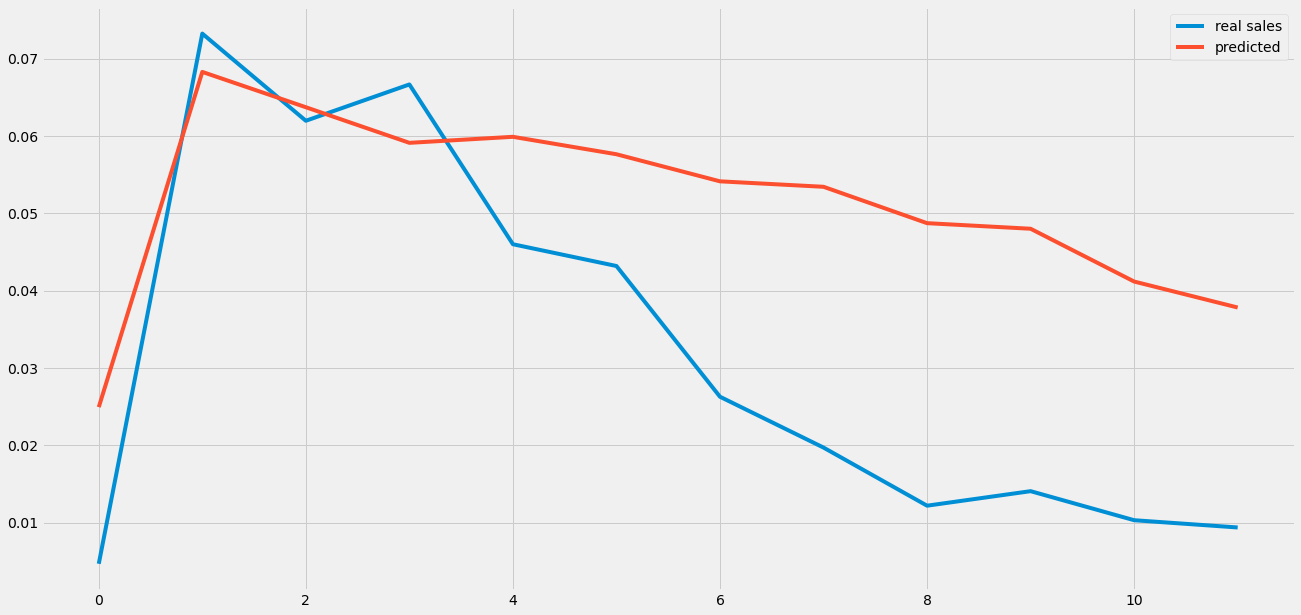

In [10]:
ii = 0
plt.plot(y0.values[ii,:], label="real sales")
plt.plot(mo_prediction[ii,:], label="predicted")
plt.legend()
plt.show()

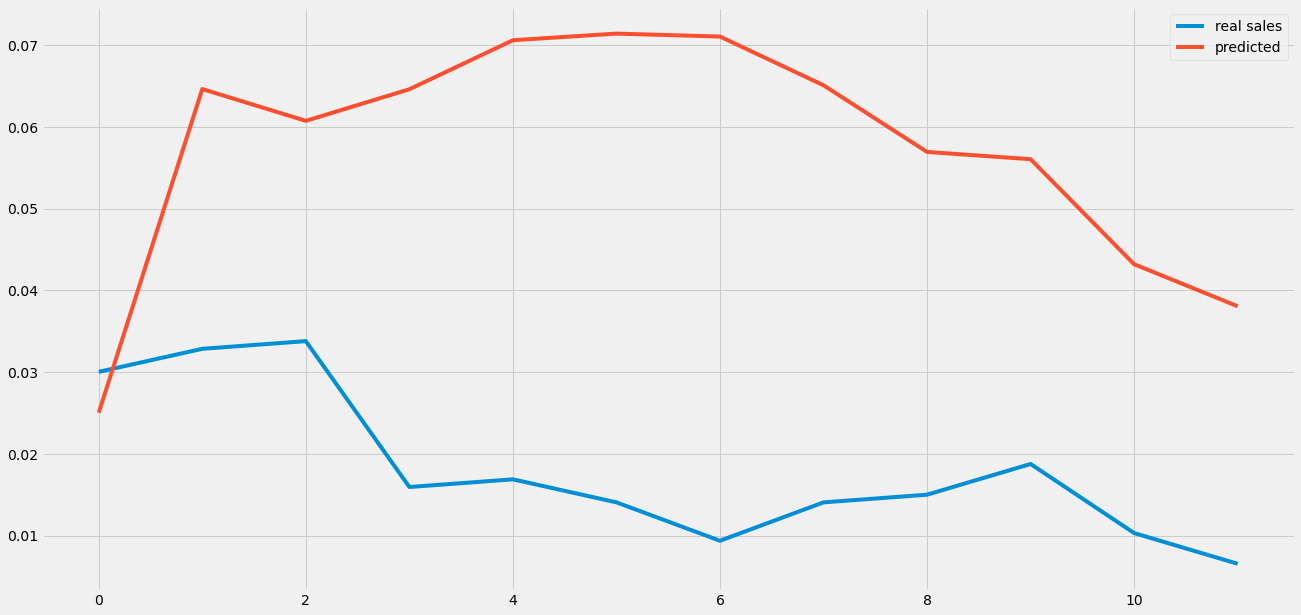

In [11]:
ii = 12
plt.plot(y0.values[ii,:], label="real sales")
plt.plot(mo_prediction[ii,:], label="predicted")
plt.legend()
plt.show()

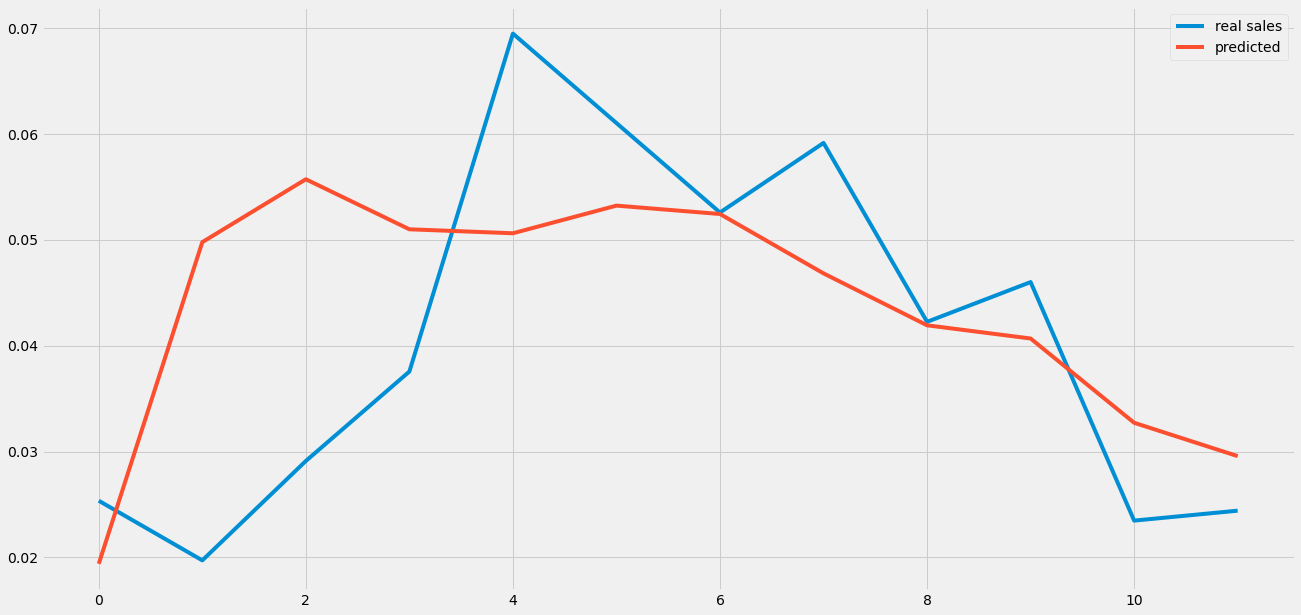

In [12]:
ii = 80
plt.plot(y0.values[ii,:], label="real sales")
plt.plot(mo_prediction[ii,:], label="predicted")
plt.legend()
plt.show()

It's not working so well. What else can we try?
## Embeddings
Alternative approach:
- create embeddings for the categorical part with cat2vec https://openreview.net/pdf?id=HyNxRZ9xg
- cluster the products for which we know the sales
- calculate average target per cluster
- map the new ones to the nearest cluster

In [13]:
def correct_time(df):
    """

    :param df:
    :return:
    """
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['week'] = df.release_date.dt.isocalendar().week
    df['month'] = df.release_date.dt.month
    df['day'] = df.release_date.dt.day


correct_time(xtrain)
correct_time(xtest)

In [14]:
# split into targets and variables we will use for clustering
target_cols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
cat_cols = ['category', 'day', 'week', 'month', 'color', 'fabric', 'extra' ]
y0, y1 = xtrain[target_cols].copy(), xtest[target_cols].copy()
x0, x1 = xtrain[cat_cols].copy(), xtest[cat_cols].copy()

Implementation from https://www.kaggle.com/code/classtag/cat2vec-powerful-feature-for-categorical
### Cat2vec

In [15]:
def apply_w2v(sentences, model, num_features):
    """

    :param sentences:
    :param model:
    :param num_features:
    :return:
    """
    def _average_word_vectors(words, model, vocabulary, num_features):
        """

        :param words:
        :param model:
        :param vocabulary:
        :param num_features:
        :return:
        """
        feature_vector = np.zeros((num_features,), dtype="float64")
        n_words = 0.
        for word in words:
            if word in vocabulary:
                n_words = n_words + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if n_words:
            feature_vector = np.divide(feature_vector, n_words)
        return feature_vector
    vocab = set(model.wv.index_to_key)
    feats = [_average_word_vectors(s, model, vocab, num_features) for s in sentences]
    return np.array(feats)


def gen_cat2vec_sentences(data):
    """

    :param data:
    :return:
    """
    X_w2v = copy.deepcopy(data)
    names = list(X_w2v.columns.values)
    for c in names:
        X_w2v[c] = X_w2v[c].fillna('unknow').astype('category')
        X_w2v[c].cat.categories = ["%s %s" % (c, g) for g in X_w2v[c].cat.categories]
    X_w2v = X_w2v.values.tolist()
    return X_w2v


def fit_cat2vec_model(data):
    """

    :param data:
    :return:
    """
    X_w2v = gen_cat2vec_sentences(data)
    for i in X_w2v:
        shuffle(i)
    model = Word2Vec(X_w2v, vector_size=10, window=3)
    return model

In [16]:
# fit a cat2vec
c2v_model = fit_cat2vec_model(pd.concat([x0,x1], axis=0))

In [17]:
# generate the embeddings
x0_c2v = apply_w2v(gen_cat2vec_sentences(x0), c2v_model, 10)
x1_c2v = apply_w2v(gen_cat2vec_sentences(x1), c2v_model, 10)

In [18]:
# fit kmeans
clustering = KMeans(n_clusters=10)
clustering.fit(x0_c2v)
y0_clusters = clustering.predict(x0_c2v)

In [19]:
# assign the clusters for the test set
y1_clusters = clustering.predict(x1_c2v)

### Mapping

In [20]:
cl_prediction = np.zeros(y1.shape)
for ii in range(10):
    cl_prediction[y1_clusters == ii,:] = y0.loc[y0_clusters == ii].mean()

In [21]:
print('(sort of) MSE: ' + str(np.round(np.sqrt(np.average((cl_prediction - y1) ** 2)), 4)))

(sort of) MSE: 0.0507


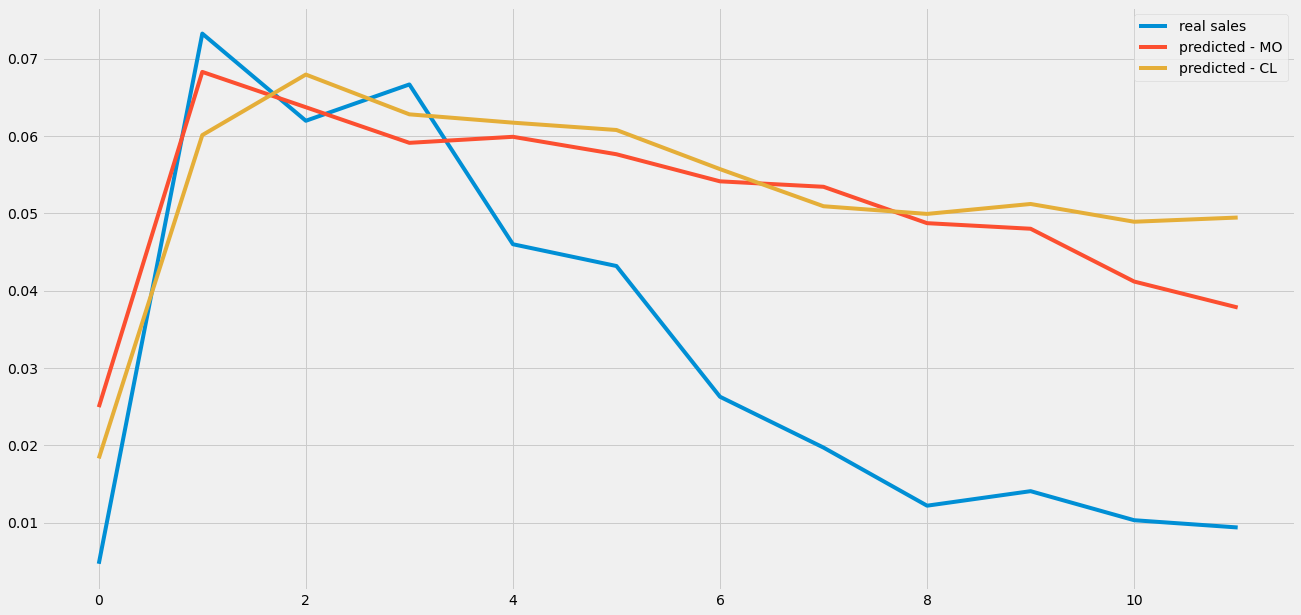

In [22]:
ii = 0
plt.plot(y0.values[ii,:], label="real sales")
plt.plot(mo_prediction[ii,:], label="predicted - MO")
plt.plot(cl_prediction[ii,:], label="predicted - CL")
plt.legend()
plt.show()

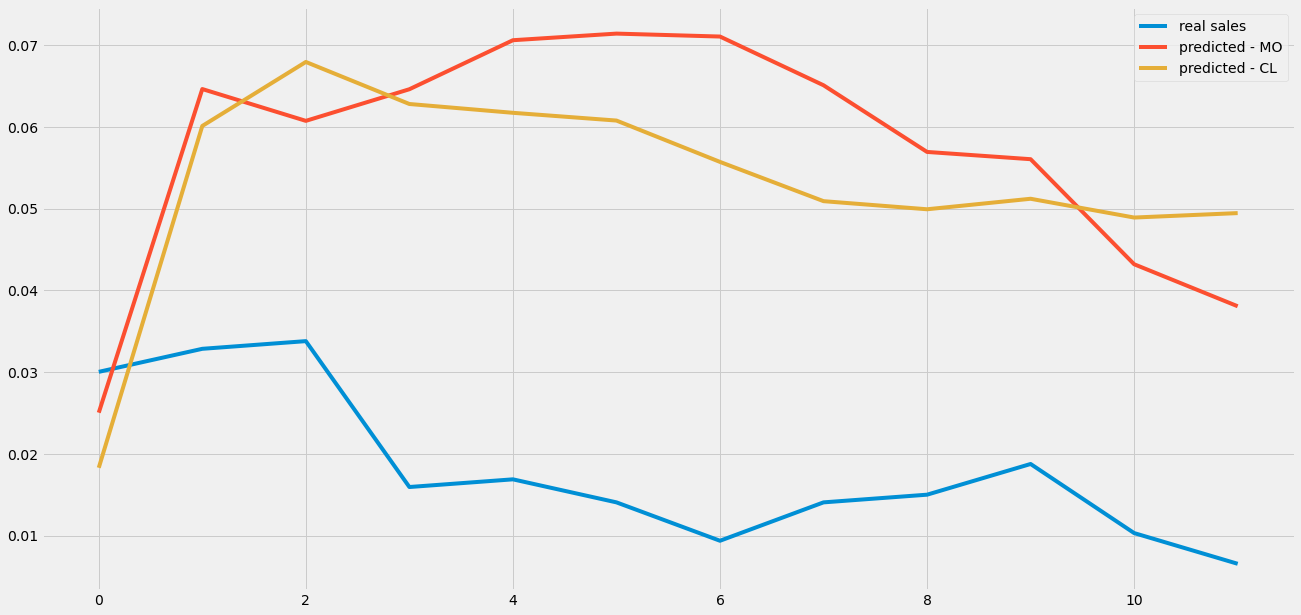

In [23]:
ii = 12
plt.plot(y0.values[ii,:], label="real sales")
plt.plot(mo_prediction[ii,:], label="predicted - MO")
plt.plot(cl_prediction[ii,:], label="predicted - CL")
plt.legend()
plt.show()

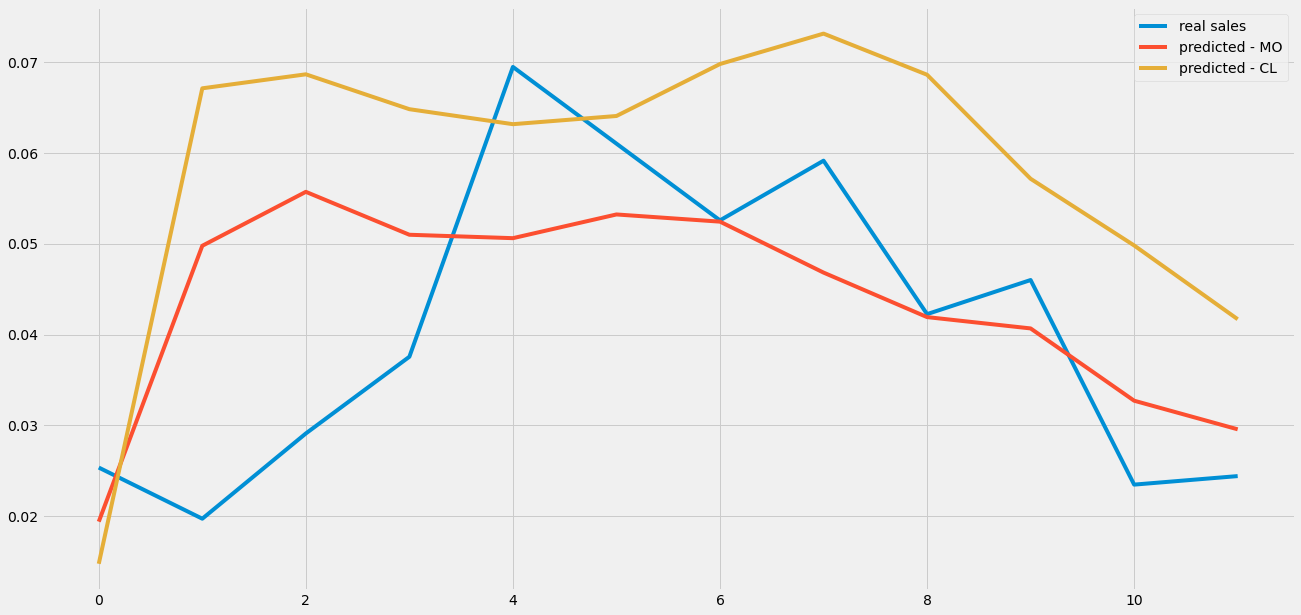

In [24]:
ii = 80
plt.plot(y0.values[ii,:], label="real sales")
plt.plot(mo_prediction[ii,:], label="predicted - MO")
plt.plot(cl_prediction[ii,:], label="predicted - CL")
plt.legend()
plt.show()

This concludes our adventure in demand prediction territory:

### Summary:
- hybrid approach to predicting new products